# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [110]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score

In [106]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Take a look at the data

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


# Data Cleaning and Accessing

## First, we will look at Portfolio Data

In [7]:
# number of rows and columns
portfolio.shape

(10, 6)

In [9]:
# basic info about the data
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [11]:
# stats about the data
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [19]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [20]:
profile[profile['age']== 118].age.count()

2175

In [21]:
# gender and income are missing where age is 118
profile[profile['age']== 118].drop(['became_member_on' ,'id'], axis=1)

,age,gender,income
0,118,None,NaN
2,118,None,NaN
4,118,None,NaN
6,118,None,NaN
7,118,None,NaN
9,118,None,NaN
10,118,None,NaN
11,118,None,NaN
17,118,None,NaN
23,118,None,NaN


In [22]:
# All missing age values are encoded as 118

In [37]:
# cleaning portfolio data
cleaned_portfolio = portfolio.rename(columns = {'difficulty':'offer_difficulty' , 'id':'offer_id', 'duration':'offer_duration', 'reward': 'offer_reward'})
cleaned_portfolio.head()

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


## Now we will explore profile data and then clean it

In [13]:
# print first 5 rows
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [14]:
# number of rows and columns
profile.shape

(17000, 5)

In [16]:
# basic info about the dataset
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [17]:
# some stats about the data
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [18]:
# checking number of null values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [23]:
profile.age.value_counts()

118    2175
58      408
53      372
51      363
54      359
59      359
57      353
52      351
55      350
56      342
63      338
60      333
49      321
62      318
67      317
64      311
61      309
48      288
50      284
66      284
65      280
68      259
70      252
69      242
47      232
45      231
71      230
42      227
43      215
46      212
       ... 
22      131
30      131
29      129
23      126
81      118
35      118
79      117
80      116
31      113
82      105
83      102
84       83
18       70
85       70
87       66
88       64
86       54
89       53
90       52
91       47
92       40
94       33
93       29
95       22
97       13
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

In [24]:
profile[(profile['age'] > 80) & (profile['age'] < 118)]

,age,became_member_on,gender,id,income
33,96,20171117,F,868317b9be554cb18e50bc68484749a2,89000.0
94,89,20171114,F,4264b1d027cc493281bba4f44bfedaca,87000.0
98,90,20151210,F,1c587de019994f93a242c6864fd7bc55,98000.0
126,83,20180127,M,4c29d22467af4d7faa137c4eedd65340,46000.0
131,89,20180114,F,3dae0eadb47149b0b9b548d14548524b,65000.0
167,85,20180726,M,4e233f02eff840c7a3e5ec15d55d7d23,67000.0
186,82,20161231,M,c79da41557894c7eacc5c0156dc1f4dc,87000.0
202,81,20180503,M,accec36a10704e1fbaeb9b28b8bc5da8,93000.0
210,82,20180319,M,d2e88e95c0ae41c0980e4cfc10d162d8,73000.0
214,82,20180108,M,5a3d291f75984396b6eb2800206ec716,72000.0


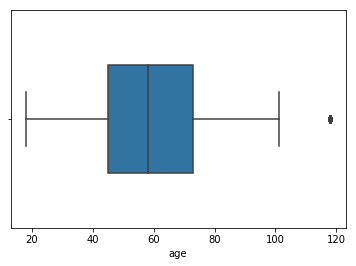

In [25]:
sns.boxplot(profile['age'], width=0.5);

Here people after age of 80 are outliers

In [39]:
# cleaning profile data
cleaned_profile = profile.rename(columns={'id':'customer_id' , 'income':'customer_income'})
cleaned_profile.replace(118, np.nan , inplace=True)
#replace NaN age values with mean age
cleaned_profile['age'] = cleaned_profile['age'].fillna(cleaned_profile['age'].mean())
#replace missing income values with mean income
cleaned_profile['customer_income'] = cleaned_profile['customer_income'].fillna(cleaned_profile['customer_income'].mean())
#replace missing gender values with mode i.e. most frequent gender
mode = cleaned_profile['gender'].mode()[0]
cleaned_profile['gender'] = cleaned_profile['gender'].fillna(mode)
#remove outliers
cleaned_profile = cleaned_profile[cleaned_profile['age'] <= 80]
cleaned_profile['age'] = cleaned_profile['age'].astype(int)
#add Age_group column
cleaned_profile.loc[(cleaned_profile.age < 20) , 'Age_group'] = 'Under 20'
cleaned_profile.loc[(cleaned_profile.age >= 20) & (cleaned_profile.age <= 45) , 'Age_group'] = '20-45'
cleaned_profile.loc[(cleaned_profile.age >= 46) & (cleaned_profile.age <= 60) , 'Age_group'] = '46-60'
cleaned_profile.loc[(cleaned_profile.age >= 61) , 'Age_group'] = '61-80'
cleaned_profile.drop('age',axis=1,inplace=True)
cleaned_profile.head()

,became_member_on,gender,customer_id,customer_income,Age_group
0,20170212,M,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,46-60
1,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.000000,46-60
2,20180712,M,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,46-60
3,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,61-80
4,20170804,M,a03223e636434f42ac4c3df47e8bac43,65404.991568,46-60


## Now we will explore transcript data and then clean it

In [28]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [29]:
# number of rows and columns
transcript.shape

(306534, 4)

In [30]:
# info about the transcript data
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [31]:
# stats about the transcript data
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


It seems like there is an entire dictionaries in each row of value column

In [32]:
# unique values in event column
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [33]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [34]:
#check for null values
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [40]:
# cleaning transcript data
cleaned_transcript = transcript.rename(columns={'person':'customer_id'})
cleaned_transcript['offer_id'] = cleaned_transcript['value'].apply(lambda x: x.get('offer_id'))
cleaned_transcript['offer id'] = cleaned_transcript['value'].apply(lambda x: x.get('offer id'))
cleaned_transcript['money_gained'] = cleaned_transcript['value'].apply(lambda x: x.get('reward'))
cleaned_transcript['money_spent'] = cleaned_transcript['value'].apply(lambda x: x.get('amount'))
#move 'offer id' values into 'offer_id'
cleaned_transcript['offer_id'] = cleaned_transcript.apply(lambda x : x['offer id'] if x['offer_id'] == None else x['offer_id'], axis=1)
#drop 'offer id' column 
cleaned_transcript.drop(['offer id' , 'value'] , axis=1, inplace=True)
#replace nan
cleaned_transcript.fillna(0 , inplace=True)
cleaned_transcript.head()

,event,customer_id,time,offer_id,money_gained,money_spent
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


### Now, we will merge all the three dataframes together

In [41]:
merged_df = pd.merge(cleaned_portfolio, cleaned_transcript, on='offer_id')
merged_df = pd.merge(merged_df, cleaned_profile, on='customer_id')

In [42]:
merged_df.head()

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward,event,customer_id,time,money_gained,money_spent,became_member_on,gender,customer_income,Age_group
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,0.0,0.0,20170909,M,100000.0,61-80
1,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,102,0.0,0.0,20170909,M,100000.0,61-80
2,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,504,0.0,0.0,20170909,M,100000.0,61-80
3,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,510,0.0,0.0,20170909,M,100000.0,61-80
4,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,510,10.0,0.0,20170909,M,100000.0,61-80


In [44]:
# number of rows and columns in merged df
merged_df.shape

(157503, 15)

In [45]:
# stats about merged data
merged_df.describe()

,offer_difficulty,offer_duration,offer_reward,time,money_gained,money_spent,became_member_on,customer_income
count,157503.000000,157503.000000,157503.000000,157503.000000,157503.000000,157503.0,1.575030e+05,157503.000000
mean,7.853400,6.612852,4.418792,353.560694,0.970845,0.0,2.016662e+07,65924.491100
std,5.051261,2.136873,3.371961,198.310352,2.335628,0.0,1.166203e+04,20068.408857
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.0,2.013073e+07,30000.000000
25%,5.000000,5.000000,2.000000,168.000000,0.000000,0.0,2.016051e+07,52000.000000
50%,10.000000,7.000000,5.000000,408.000000,0.000000,0.0,2.017070e+07,65404.991568
75%,10.000000,7.000000,5.000000,510.000000,0.000000,0.0,2.017122e+07,77000.000000
max,20.000000,10.000000,10.000000,714.000000,10.000000,0.0,2.018073e+07,120000.000000


## Now, let's answer some questions using the merged_data

### What is the average income of the costumers who uses the app?

In [47]:
print('the average income of the costumers who uses the app:',merged_df['customer_income'].mean())

the average income of the costumers who uses the app: 65924.4910998


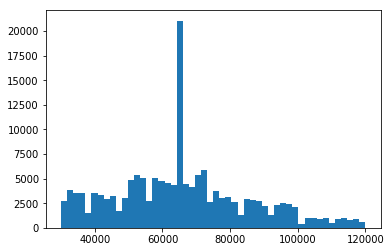

In [51]:
# Now, lets plot this
plt.hist(merged_df['customer_income'], bins=50);

## Which is the most uses offer used by the costumers?

In [53]:
merged_df['offer_type'].value_counts()

bogo             67294
discount         65728
informational    24481
Name: offer_type, dtype: int64

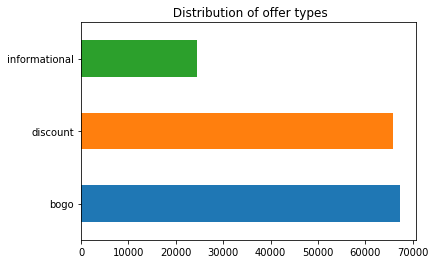

In [57]:
# let's plot this 
merged_df['offer_type'].value_counts().plot.barh(title=' Distribution of offer types');

Here we can clearly see that discount and BOGO offers have almost same distributions

## What is the distribution of age in the merged_df?

In [67]:
merged_df['Age_group'].value_counts()

46-60       68987
61-80       46280
20-45       40343
Under 20     1893
Name: Age_group, dtype: int64

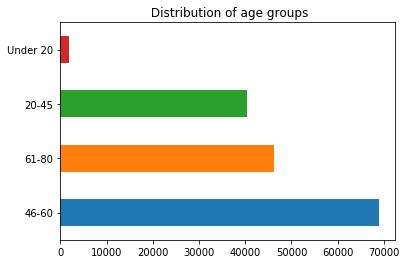

In [72]:
# now plotting distribution of age groups
merged_df['Age_group'].value_counts().plot.barh(title=' Distribution of age groups');

## What are the Actions to the offers that customers received?

In [74]:
event_values = merged_df['event'].value_counts()
event_values

offer received     71863
offer viewed       54396
offer completed    31244
Name: event, dtype: int64

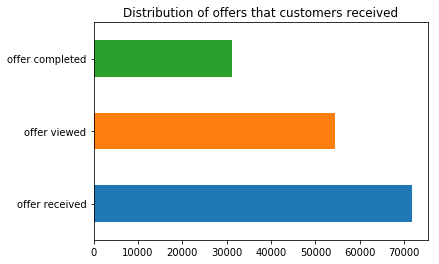

In [76]:
event_values.plot.barh(title = 'Distribution of offers that customers received');

# What is the gender distributions for each age groups?

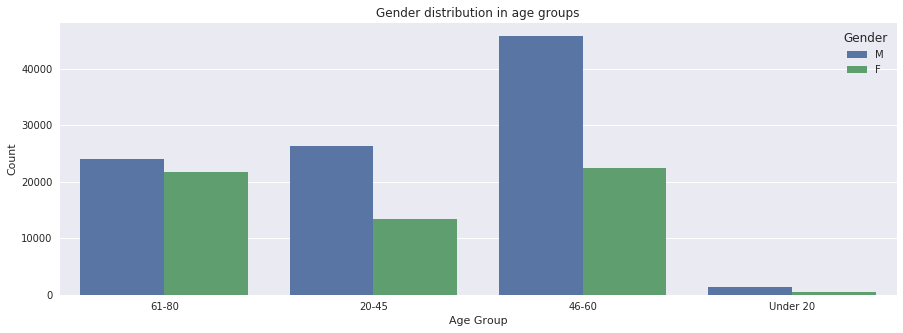

In [79]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "Age_group", hue= "gender", data=merged_df[merged_df['gender'] != 'O'])
sns.set(style="darkgrid")
plt.title('Gender distribution in age groups')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender')
plt.show();

Here we can clearly see that in all age groups males are more than female costumers.

## what is a gender distributions for each offer type?

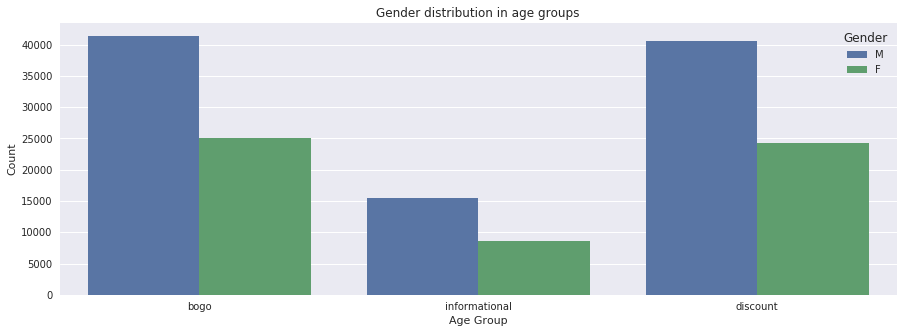

In [81]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_type", hue= "gender", data=merged_df[merged_df['gender'] != 'O'])
sns.set(style="darkgrid")
plt.title('Gender distribution in age groups')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender')
plt.show();

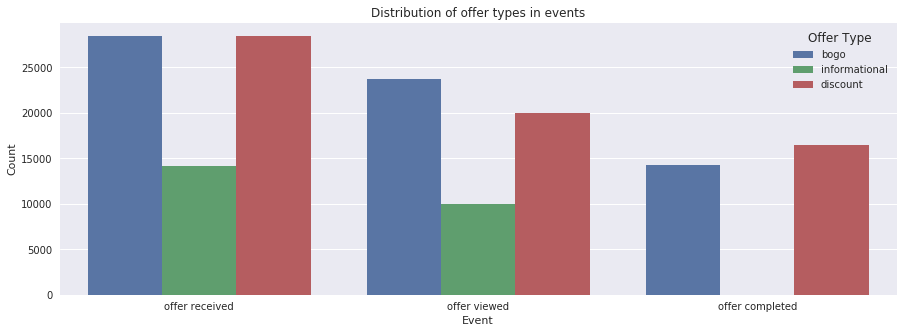

In [85]:
# Which is the offer type which is completed more than other offer types?
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "offer_type", data=merged_df[merged_df['gender'] != 'O'])
sns.set(style="darkgrid")
plt.title('Distribution of offer types in events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Offer Type')
plt.show();

## From this we can clearly see that Discount offer is the mpst used offer by all the costumers who uses the application

# Machine Learning

We will use the machine learning techniques to predict the responses of the user to an offer. but first of all we need to prepare our data to apply ML models. So let's get started with data preparation and cleaning

In [91]:
# applying one hot encoding to gender, offertype, channel and age groups
df = pd.get_dummies(merged_df,columns = ['offer_type', 'gender', 'Age_group'])
df = df.drop('channels', 1).join(df.channels.str.join('|').str.get_dummies())

In [92]:
df.head()

,offer_difficulty,offer_duration,offer_id,offer_reward,event,customer_id,time,money_gained,money_spent,became_member_on,...,gender_M,gender_O,Age_group_20-45,Age_group_46-60,Age_group_61-80,Age_group_Under 20,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,0.0,0.0,20170909,...,1,0,0,0,1,0,1,1,1,0
1,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,102,0.0,0.0,20170909,...,1,0,0,0,1,0,1,1,1,0
2,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,504,0.0,0.0,20170909,...,1,0,0,0,1,0,1,1,1,0
3,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,510,0.0,0.0,20170909,...,1,0,0,0,1,0,1,1,1,0
4,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,510,10.0,0.0,20170909,...,1,0,0,0,1,0,1,1,1,0


In [93]:
# Now, we will encode the event data to int values as recived is 1, viewed is 2 and completed is 3
df['event'] = df['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})

In [94]:
df.head()

,offer_difficulty,offer_duration,offer_id,offer_reward,event,customer_id,time,money_gained,money_spent,became_member_on,...,gender_M,gender_O,Age_group_20-45,Age_group_46-60,Age_group_61-80,Age_group_Under 20,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,4b0da7e80e5945209a1fdddfe813dbe0,0,0.0,0.0,20170909,...,1,0,0,0,1,0,1,1,1,0
1,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,2,4b0da7e80e5945209a1fdddfe813dbe0,102,0.0,0.0,20170909,...,1,0,0,0,1,0,1,1,1,0
2,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,4b0da7e80e5945209a1fdddfe813dbe0,504,0.0,0.0,20170909,...,1,0,0,0,1,0,1,1,1,0
3,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,2,4b0da7e80e5945209a1fdddfe813dbe0,510,0.0,0.0,20170909,...,1,0,0,0,1,0,1,1,1,0
4,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,3,4b0da7e80e5945209a1fdddfe813dbe0,510,10.0,0.0,20170909,...,1,0,0,0,1,0,1,1,1,0


In [95]:
#Now encoding offer_id
off_id = df['offer_id'].unique().tolist()
o_mapping = dict( zip(off_id,range(len(off_id))))
df.replace({'offer_id': o_mapping},inplace=True)

In [97]:
df.head(10)

,offer_difficulty,offer_duration,offer_id,offer_reward,event,customer_id,time,money_gained,money_spent,became_member_on,...,gender_M,gender_O,Age_group_20-45,Age_group_46-60,Age_group_61-80,Age_group_Under 20,email,mobile,social,web
0,10,7,0,10,1,4b0da7e80e5945209a1fdddfe813dbe0,0,0.0,0.0,20170909,...,1,0,0,0,1,0,1,1,1,0
1,10,7,0,10,2,4b0da7e80e5945209a1fdddfe813dbe0,102,0.0,0.0,20170909,...,1,0,0,0,1,0,1,1,1,0
2,10,7,0,10,1,4b0da7e80e5945209a1fdddfe813dbe0,504,0.0,0.0,20170909,...,1,0,0,0,1,0,1,1,1,0
3,10,7,0,10,2,4b0da7e80e5945209a1fdddfe813dbe0,510,0.0,0.0,20170909,...,1,0,0,0,1,0,1,1,1,0
4,10,7,0,10,3,4b0da7e80e5945209a1fdddfe813dbe0,510,10.0,0.0,20170909,...,1,0,0,0,1,0,1,1,1,0
5,0,4,1,0,1,4b0da7e80e5945209a1fdddfe813dbe0,408,0.0,0.0,20170909,...,1,0,0,0,1,0,1,1,0,1
6,0,4,1,0,2,4b0da7e80e5945209a1fdddfe813dbe0,468,0.0,0.0,20170909,...,1,0,0,0,1,0,1,1,0,1
7,20,10,2,5,1,4b0da7e80e5945209a1fdddfe813dbe0,168,0.0,0.0,20170909,...,1,0,0,0,1,0,1,0,0,1
8,20,10,2,5,2,4b0da7e80e5945209a1fdddfe813dbe0,174,0.0,0.0,20170909,...,1,0,0,0,1,0,1,0,0,1
9,20,10,2,5,3,4b0da7e80e5945209a1fdddfe813dbe0,180,5.0,0.0,20170909,...,1,0,0,0,1,0,1,0,0,1


In [101]:
#Now encoding costumer_id
cusids = df['customer_id'].unique().tolist()
c_mapping = dict( zip(cusids,range(len(cusids))) )
df.replace({'customer_id': c_mapping},inplace=True)

In [102]:
df.head()

,offer_difficulty,offer_duration,offer_id,offer_reward,event,customer_id,time,money_gained,money_spent,became_member_on,...,gender_M,gender_O,Age_group_20-45,Age_group_46-60,Age_group_61-80,Age_group_Under 20,email,mobile,social,web
0,10,7,0,10,1,0,0,0.0,0.0,20170909,...,1,0,0,0,1,0,1,1,1,0
1,10,7,0,10,2,0,102,0.0,0.0,20170909,...,1,0,0,0,1,0,1,1,1,0
2,10,7,0,10,1,0,504,0.0,0.0,20170909,...,1,0,0,0,1,0,1,1,1,0
3,10,7,0,10,2,0,510,0.0,0.0,20170909,...,1,0,0,0,1,0,1,1,1,0
4,10,7,0,10,3,0,510,10.0,0.0,20170909,...,1,0,0,0,1,0,1,1,1,0


In [103]:
# creating seperate year and month column from becoame_member_on
df['became_member_on'] = df['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df['month_Became_member'] = df['became_member_on'].apply(lambda x: x.day)
df['year_Became_member'] = df['became_member_on'].apply(lambda x: x.year)
df.drop('became_member_on',axis=1, inplace=True)

In [104]:
df.head()

,offer_difficulty,offer_duration,offer_id,offer_reward,event,customer_id,time,money_gained,money_spent,customer_income,...,Age_group_20-45,Age_group_46-60,Age_group_61-80,Age_group_Under 20,email,mobile,social,web,month_Became_member,year_Became_member
0,10,7,0,10,1,0,0,0.0,0.0,100000.0,...,0,0,1,0,1,1,1,0,9,2017
1,10,7,0,10,2,0,102,0.0,0.0,100000.0,...,0,0,1,0,1,1,1,0,9,2017
2,10,7,0,10,1,0,504,0.0,0.0,100000.0,...,0,0,1,0,1,1,1,0,9,2017
3,10,7,0,10,2,0,510,0.0,0.0,100000.0,...,0,0,1,0,1,1,1,0,9,2017
4,10,7,0,10,3,0,510,10.0,0.0,100000.0,...,0,0,1,0,1,1,1,0,9,2017


In [108]:
# now we will scale and normalize the numerical data
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['customer_income', 'offer_difficulty', 'offer_duration', 'offer_reward', 'time', 'money_gained', 'money_spent']
df[numerical] = scaler.fit_transform(df[numerical])

In [109]:
df.head()

,offer_difficulty,offer_duration,offer_id,offer_reward,event,customer_id,time,money_gained,money_spent,customer_income,...,Age_group_20-45,Age_group_46-60,Age_group_61-80,Age_group_Under 20,email,mobile,social,web,month_Became_member,year_Became_member
0,0.5,0.571429,0,1.0,1,0,0.000000,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
1,0.5,0.571429,0,1.0,2,0,0.142857,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
2,0.5,0.571429,0,1.0,1,0,0.705882,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
3,0.5,0.571429,0,1.0,2,0,0.714286,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
4,0.5,0.571429,0,1.0,3,0,0.714286,1.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017


In [111]:
# Now we our data is ready for machine learning model
# spliting train and test data
data = df.drop('event',axis=1)
label = df['event']
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size = 0.3, random_state = 0)

In [112]:
# training our model

def train_test(clf):
    """
    Returns the model name along with the f1 score
    """
    train_prediction =  (clf.fit(X_train, y_train)).predict(X_train)
    test_predictions = (clf.fit(X_train, y_train)).predict(X_test)
    train_f1 =  accuracy_score(y_train, train_prediction)*100
    test_f1= fbeta_score(y_test, test_predictions, beta = 0.5, average='micro' )*100
    name = clf.__class__.__name__
    
    return train_f1, test_f1, name

## Now, I will use RandomForestClassifier

In [113]:
clf_A = RandomForestClassifier(random_state = 10)
a_train_f1, a_test_f1, a_model = train_test(clf_A)

In [117]:
print(a_model, a_train_f1, a_test_f1)

RandomForestClassifier 93.6581649312 68.9212926711


## Now using DecisionTreeClassifier

In [118]:
clf_b = DecisionTreeClassifier(random_state = 10)
b_train_f1, b_test_f1, b_model = train_test(clf_b)

In [119]:
print(b_model, b_train_f1, b_test_f1)

DecisionTreeClassifier 94.7030439357 84.8913250513


# Conclusions

**We have plotted various distributions in this notebooks, and from them we came to know about many things. From which some of them are:**
- There are more males in the datasets and we also come to know that males uses app more than females.
- We can clearly see that poeple from the age group 46-60 uses apps the most.
- Discount offer is used most by the costumers.


**Comparing our models using F1 score**

In [123]:
mod = {'Model': [a_model, b_model], 'train F1 score ':[a_train_f1, b_train_f1,], 'test F1 score': [a_test_f1 , b_test_f1,] }
df_mod_comp = pd.DataFrame(mod)
df_mod_comp

,Model,train F1 score,test F1 score
0,RandomForestClassifier,93.658165,68.921293
1,DecisionTreeClassifier,94.703044,84.891325


Here our both models have performed well. DescisionTree has the best score on validation set data which is 84.9. The RandomForestClassifier performed well on train data but not that good on test(Validation) data. But this problem which we are trying to solve can also be solved with RandomForestClassifier as it don't need to require high F1 score. So to predict a costumer response to a offer we can use any of the two offers.

# Further Improvements 
As Today is the last day of my Udacity Subscription I have not get enough time to try more things on this project. But in near future, I will definately do some model tuning, feature engineering and try to improve the model performance.

I am also thinking to try Clustering techniques on this dataset.

At last, I am also thinking to make a webapp for this problem statement.

#### Converting to a HTML FILE

In [126]:
!jupyter nbconvert --to html Starbucks_Capstone_notebook.ipynb  

[NbConvertApp] Converting notebook Starbucks_Capstone_notebook.ipynb to html
[NbConvertApp] Writing 533771 bytes to Starbucks_Capstone_notebook.html
